In [1]:
import torch
import torchvision
import os
import sys
import numpy as np
import submitit
from tqdm import trange
from collections import defaultdict
from pathlib import Path
from speedrun import BaseExperiment, WandBMixin, IOMixin, register_default_dispatch
from torch_db import Tracer
import matplotlib.pyplot as plt
from jumping_quadrupeds.buffer import ReplayBufferStorage
from jumping_quadrupeds.env import make_env
from jumping_quadrupeds.utils import DataSpec, preprocess_obs, set_seed, build_loader
from jumping_quadrupeds.ppo.agent import PPOAgent
from jumping_quadrupeds.drqv2.agent import DrQV2Agent
from jumping_quadrupeds.spr.agent import SPRAgent
from jumping_quadrupeds.mae.agent import MAEAgent
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange



In [2]:

os.chdir("..")
%matplotlib inline

In [35]:
# helpers
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    


In [4]:
class Trainer(BaseExperiment, WandBMixin, IOMixin, submitit.helpers.Checkpointable):
    WANDB_ENTITY = "jumping_quadrupeds"
    WANDB_PROJECT = "rl-encoder-test"

    def __init__(trainer):
        super(Trainer, trainer).__init__()
        trainer.auto_setup()

        if trainer.get("use_wandb"):
            trainer.initialize_wandb()

        # env setup
        seed = set_seed(seed=trainer.get("seed"))
        trainer.env = make_env(seed=seed, **trainer.get("env/kwargs"))
        trainer.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        trainer.episode_returns = defaultdict(list)
        trainer.ep_idx = 0

        trainer._build_buffer()
        trainer._build_agent()

    def _build_buffer(trainer):
        data_specs = [
            DataSpec("obs", trainer.env.observation_space.shape, np.uint8),
            DataSpec("act", trainer.env.action_space.shape, np.float32),
            DataSpec("rew", (1,), np.float32),
            DataSpec("val", (1,), np.float32),
            DataSpec("discount", (1,), np.float32),
            DataSpec("logp", trainer.env.action_space.shape, np.float32),
        ]

        replay_dir = Path(trainer.experiment_directory + "/Logs/buffer")
        trainer.replay_storage = ReplayBufferStorage(data_specs, replay_dir)
        trainer.replay_loader = build_loader(replay_dir, **trainer.get("buffer/kwargs"))
        trainer._replay_iter = None

    @property
    def replay_iter(trainer):
        if trainer._replay_iter is None:
            trainer._replay_iter = iter(trainer.replay_loader)
        return trainer._replay_iter

    def _build_agent(trainer):
        if trainer.get("agent/name") == "ppo":
            trainer.agent = PPOAgent(trainer.env.observation_space,
                                  trainer.env.action_space,
                                  trainer.get("use_wandb"),
                                  device=trainer.device,
                                  **trainer.get("agent/kwargs"))
            if trainer.get("use_wandb"):
                trainer.wandb_watch(trainer.agent.ac.pi, log_freq=1)
                trainer.wandb_watch(trainer.agent.ac.v, log_freq=1)

        elif trainer.get("agent/name") == "drqv2":
            trainer.agent = DrQV2Agent(
                trainer.env.observation_space,
                trainer.env.action_space,
                trainer.device,
                **trainer.get("agent/kwargs"),
            )
        elif trainer.get("agent/name") == "spr":
            trainer.agent = SPRAgent(
                trainer.env.observation_space,
                trainer.env.action_space,
                trainer.device,
                trainer.get("buffer/kwargs/jumps"),
                **trainer.get("agent/kwargs"),
            )
        elif trainer.get("agent/name") == "mae":
            trainer.agent = MAEAgent(
                trainer.env.observation_space,
                trainer.env.action_space,
                trainer.device,
                **trainer.get("agent/kwargs"),
            )
        else:
            raise ValueError(f"Unknown agent {trainer.get('agent/name')}. Have you specified an agent to use a la ` --macro templates/agents/ppo.yml' ? ")

    @property
    def checkpoint_now(trainer):
        if trainer.step % trainer.get("save_freq") == 0:
            return True
        return False

    @property
    def episode_timeout(trainer):
        return len(trainer.episode_returns[trainer.ep_idx]) == trainer.get("env/kwargs/max_ep_len")

    @property
    def update_now(trainer):
        update_every = trainer.step % trainer.get("agent/kwargs/update_every_steps") == 0 and trainer.step > 0
        gt_seed_frames = trainer.step > trainer.get("agent/kwargs/num_seed_frames")
        ep_len_gt_nstep = len(trainer.episode_returns[trainer.ep_idx]) > trainer.get("buffer/kwargs/nstep", 1)
        return update_every and gt_seed_frames and ep_len_gt_nstep

    def write_logs(trainer):
        ep_rets = list(dict(trainer.episode_returns).values())
        ep_rets = np.array([xi + [0] * (trainer.get("env/kwargs/max_ep_len") - len(xi)) for xi in ep_rets])
        full_episodic_return = ep_rets.sum(axis=1)
        if trainer.get("use_wandb"):
            trainer.wandb_log(
                **{
                    "Episode mean reward": np.mean(full_episodic_return),
                    "Episode return": full_episodic_return[-1],
                    "Episode mean length": np.mean([len(ep) for ep in trainer.episode_returns.values()]),
                    "Number of Episodes": len(trainer.episode_returns),
                }
            )
            trainer.env.send_wandb_video()


    @register_default_dispatch
    def __call__(trainer):
        obs = trainer.env.reset()
        for _ in trange(trainer.get("total_steps")):
            action, val, logp = trainer.agent.act(preprocess_obs(obs, trainer.device), trainer.step, eval_mode=False)
            next_obs, reward, done, misc = trainer.env.step(action)

            trainer.episode_returns[trainer.ep_idx].append(reward)
            trainer.next_step()
            trainer.replay_storage.add({"obs": obs, "act": action, "rew": reward, "val": val, "logp": logp})

            # Update obs (critical!)
            obs = next_obs

            if trainer.checkpoint_now:
                trainer.agent.save_checkpoint(trainer.experiment_directory, trainer.step)

            if done or trainer.episode_timeout:
                trainer.replay_storage.finish_episode()
                trainer.write_logs()
                trainer.ep_idx += 1
                obs = trainer.env.reset()

            if trainer.update_now:
                metrics = trainer.agent.update(trainer.replay_iter, trainer.step)
                if trainer.get("use_wandb"):
                    trainer.wandb_log(**metrics)



In [5]:

sys.argv = [
    sys.argv[0],
    "experiments/mae-test-2",
    "--inherit",
    "templates/base",
    "--macro",
    "templates/agents/mae.yml"
]

trainer = Trainer()


In [6]:
trainer.agent.load_checkpoint(trainer.experiment_directory, 60000)

loading checkpoint: 60000


In [44]:
obs = trainer.env.reset()
with Tracer(detach=True).trace(trainer.agent.encoder) as tracer:
    for i in range(31):
        x = preprocess_obs(obs, trainer.device)
        action, val, logp = trainer.agent.act(x, trainer.step, eval_mode=False)
        obs, reward, done, misc = trainer.env.step(action)

Track generation: 1207..1513 -> 306-tiles track


/home/martin/Applications/anaconda3/envs/jumping_quadrupeds/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [45]:
loss, pred_pixel_values, masked_indices, unmasked_indices, patches = trainer.agent.encoder(x.unsqueeze(0), eval=False)

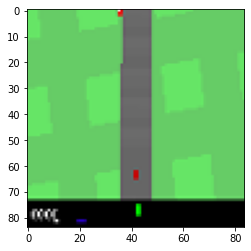

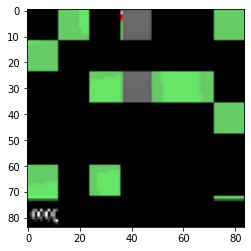

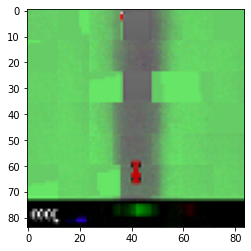

In [46]:

def visualize(pred_pixel_values, patches, seq_len=3, sample_id=0):
    masked_patch_pred = pred_pixel_values[sample_id].detach().cpu()
    masked_patch_true = patches[sample_id].cpu()

    pred_patches = rearrange(masked_patch_pred, 'p (h w c) -> p c h w', c=3, h=12, w=12)
    gt_patches = rearrange(masked_patch_true, '(p s) (h w c) -> (p s) c h w', c=3, h=12, w=12, s=seq_len)

    pred_recons = gt_patches.clone()
    pred_w_mask = gt_patches.clone()
    pred_recons[masked_indices[sample_id]] = pred_patches
    pred_w_mask[masked_indices[sample_id]] = 0.

    pred_recons = rearrange(pred_recons, '(s p1 p2) c h w -> s c (p1 h) (p2 w)', p1=7, p2=7, c=3, h=12, w=12, s=seq_len)
    pred_w_mask = rearrange(pred_w_mask, '(s p1 p2) c h w -> s c (p1 h) (p2 w)', p1=7, p2=7, c=3, h=12, w=12, s=seq_len)

    imshow(torchvision.utils.make_grid(torch.tensor(obs)))
    imshow(torchvision.utils.make_grid(pred_w_mask, nrow=7 * seq_len))
    imshow(torchvision.utils.make_grid(pred_recons.clip(0, 1), nrow=7))
    
visualize(pred_pixel_values, patches, seq_len=1, sample_id=0)

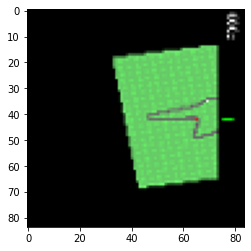

In [15]:

plt.imshow(x.T.cpu())

In [5]:
x.mean()

tensor(0.1431, device='cuda:0')

In [9]:
tracer.records.get('encoder.transformer')['output'].abs().mean()

tensor(0.9049, device='cuda:0')

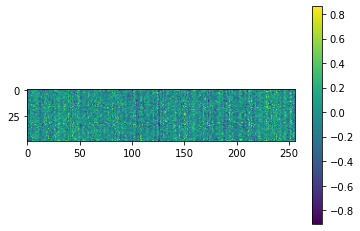

In [7]:
out1 = tracer.records.get('encoder.transformer.layers.3.1')['output'].squeeze(0)
plt.figure()
plt.imshow(out1.cpu())
plt.colorbar()
plt.show()

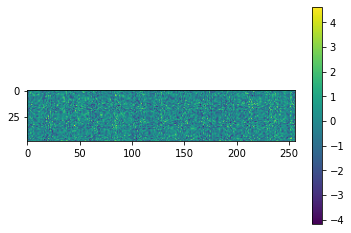

In [8]:
out2 = tracer.records.get('encoder.transformer')['output'].squeeze(0)
plt.figure()
plt.imshow(out2.cpu())
plt.colorbar()
plt.show()

In [51]:
tracer.records.get('encoder.transformer')['input'][0]

tensor(-3.9955, device='cuda:0')

In [ ]:
tracer.records.keys()

dict_keys(['encoder.to_patch_embedding.0', 'encoder.to_patch_embedding.1', 'encoder.transformer.layers.0.0.norm', 'encoder.transformer.layers.0.0.fn.to_qkv', 'encoder.transformer.layers.0.0.fn.attend', 'encoder.transformer.layers.0.0.fn.to_out.0', 'encoder.transformer.layers.0.0.fn.to_out.1', 'encoder.transformer.layers.0.0.fn.to_out', 'encoder.transformer.layers.0.0.fn', 'encoder.transformer.layers.0.0', 'encoder.transformer.layers.0.1.norm', 'encoder.transformer.layers.0.1.fn.net.0', 'encoder.transformer.layers.0.1.fn.net.1', 'encoder.transformer.layers.0.1.fn.net.2', 'encoder.transformer.layers.0.1.fn.net.3', 'encoder.transformer.layers.0.1.fn.net.4', 'encoder.transformer.layers.0.1.fn.net', 'encoder.transformer.layers.0.1.fn', 'encoder.transformer.layers.0.1', 'encoder.transformer.layers.1.0.norm', 'encoder.transformer.layers.1.0.fn.to_qkv', 'encoder.transformer.layers.1.0.fn.attend', 'encoder.transformer.layers.1.0.fn.to_out.0', 'encoder.transformer.layers.1.0.fn.to_out.1', 'encod

In [ ]:
next_obs, reward, done, misc = trainer.env.step(action)

trainer.episode_returns[trainer.ep_idx].append(reward)
trainer.next_step()
trainer.replay_storage.add({"obs": obs, "act": action, "rew": reward, "val": val, "logp": logp})

# Update obs (critical!)
obs = next_obs

if trainer.checkpoint_now:
    trainer.agent.save_checkpoint(trainer.experiment_directory, trainer.step)

if done or trainer.episode_timeout:
    trainer.replay_storage.finish_episode()
    trainer.write_logs()
    trainer.ep_idx += 1
    obs = trainer.env.reset()

if trainer.update_now:
    metrics = trainer.agent.update(trainer.replay_iter, trainer.step)
    if trainer.get("use_wandb"):
        trainer.wandb_log(**metrics)
